# Temporal Fusion Trnasformer in PyTorch

## Setup, Imports, Data Loading, Brief EDA

In [34]:
# !pip install pytorch_forecasting

In [35]:
#!pip install holidays

In [36]:
# Data loading
import pandas as pd


train = pd.read_csv('./datasets/tabular-playground-series-sep-2022/train_tft.csv')
test = pd.read_csv('./datasets/tabular-playground-series-sep-2022/test_tft.csv')

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

data = pd.concat([train, test], axis=0, ignore_index=True)

# check that key is country-store-product-date combination
assert len(data.drop_duplicates(['country', 'store', 'product', 'date'])) == len(data)

# check that there is one data per country-store-product combination
assert len(data.drop_duplicates(['country', 'store', 'product'])) == len(data)//data['date'].nunique()

display(train.sample(4))

,row_id,date,country,store,product,num_sold
40127,40127,2019-04-16,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,96
49844,49844,2019-11-05,Germany,KaggleRama,Kaggle Advanced Techniques,111
40930,40930,2019-05-03,Poland,KaggleMart,Kaggle Recipe Book,84
36321,36321,2019-01-27,Poland,KaggleMart,Kaggle Getting Started,118


### Brief EDA

- number of missing values per column

- number of unique values per column

- num_sold per country, store product, distribution and time plot

- correlation matrix

In [37]:
# Number of Nans, num_sold not present in test, its' the column we have to predict

(train.isna().sum(axis=0).rename('nans_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.isna().sum(axis=0).rename('nans_per_column_test').rename_axis('column').reset_index().set_index('column')))

,nans_per_column_train,nans_per_column_test
column,,
row_id,0,0.0
date,0,0.0
country,0,0.0
store,0,0.0
product,0,0.0
num_sold,0,NaN


In [38]:
# Number of unique values, num_sold not present in test, it's the column we have to predict

(train.nunique(axis=0).rename('n_unique_per_column_train').rename_axis('column')
 .reset_index().set_index('column')
 .join(test.nunique(axis=0).rename('n_unique_per_column_test').rename_axis('column').reset_index().set_index('column')))


,n_unique_per_column_train,n_unique_per_column_test
column,,
row_id,70128,17520.0
date,1461,365.0
country,6,6.0
store,2,2.0
product,4,4.0
num_sold,699,NaN


Text(0.5, 1.0, 'Density plot for num_sold per country (clipped at 700)')

findfont: Font family 'bold' not found.
findfont: Font family 'bold' not found.
findfont: Font family 'bold' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'bold' not found.
findfont: Font family 'bold' not found.
findfont: Font family 'bold' not found.


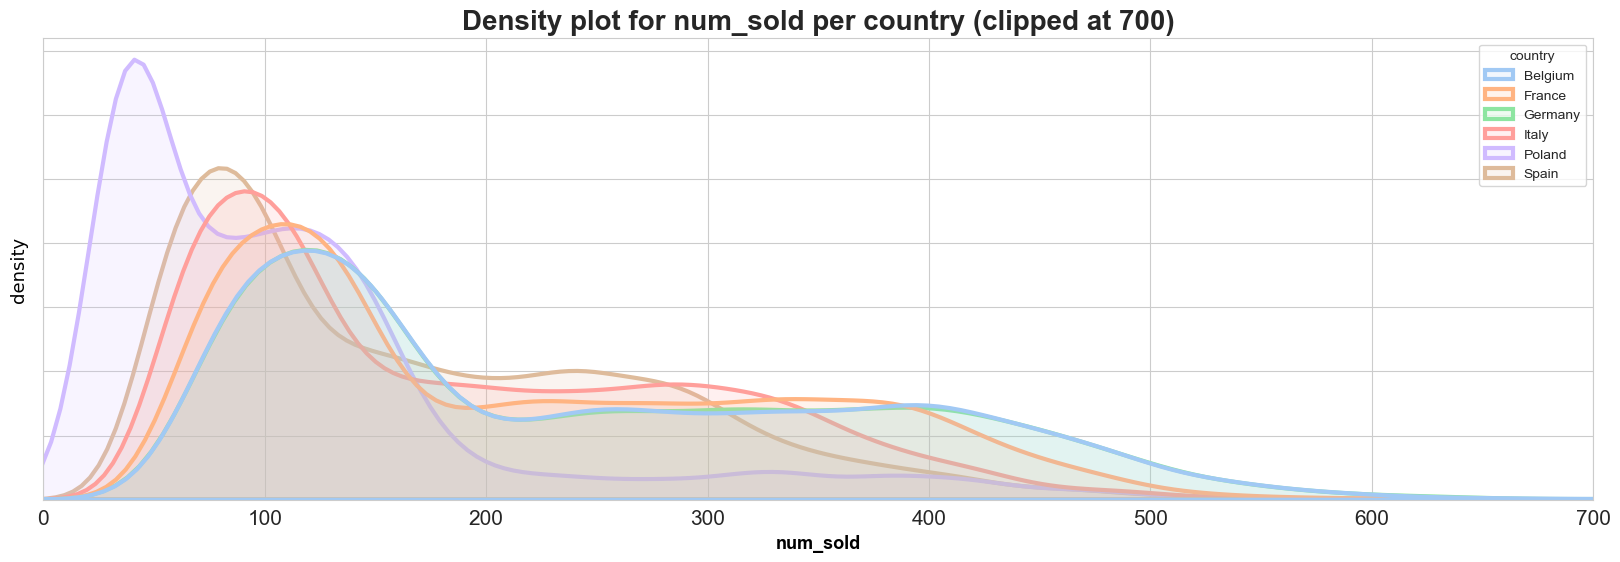

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()

fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x= 'num_sold', hue='country', fill=True, alpha=0.15, ax=ax, linewidth=3, palette='pastel')
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', font='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for num_sold per country (clipped at 700)', fontweight='bold', fontsize=20)

[Text(0, 0.0, ''),
 Text(0, 0.001, ''),
 Text(0, 0.002, ''),
 Text(0, 0.003, ''),
 Text(0, 0.004, ''),
 Text(0, 0.005, ''),
 Text(0, 0.006, '')]

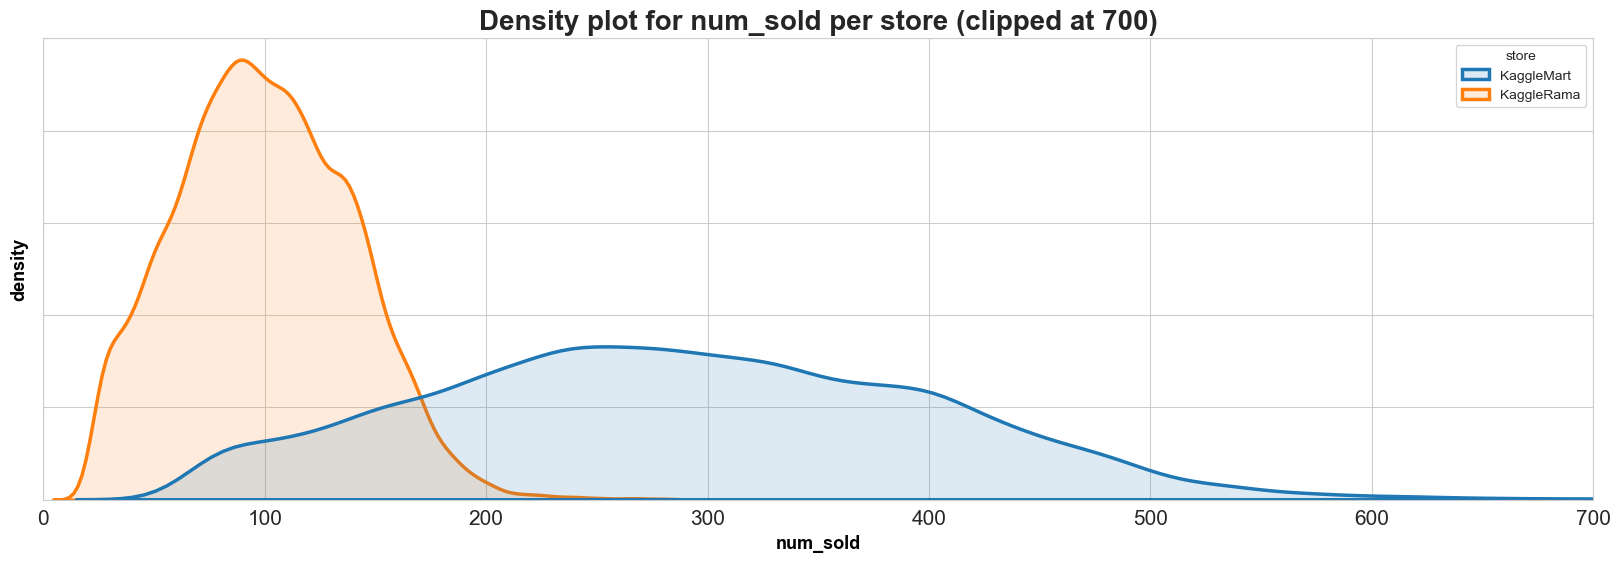

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'num_sold', hue='store', fill=True, alpha=0.15, ax=ax, linewidth=2.5)
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.set_title('Density plot for num_sold per store (clipped at 700)', fontweight='bold', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])

[Text(0, 0.0, ''),
 Text(0, 0.0005, ''),
 Text(0, 0.001, ''),
 Text(0, 0.0015, ''),
 Text(0, 0.002, ''),
 Text(0, 0.0025, ''),
 Text(0, 0.003, '')]

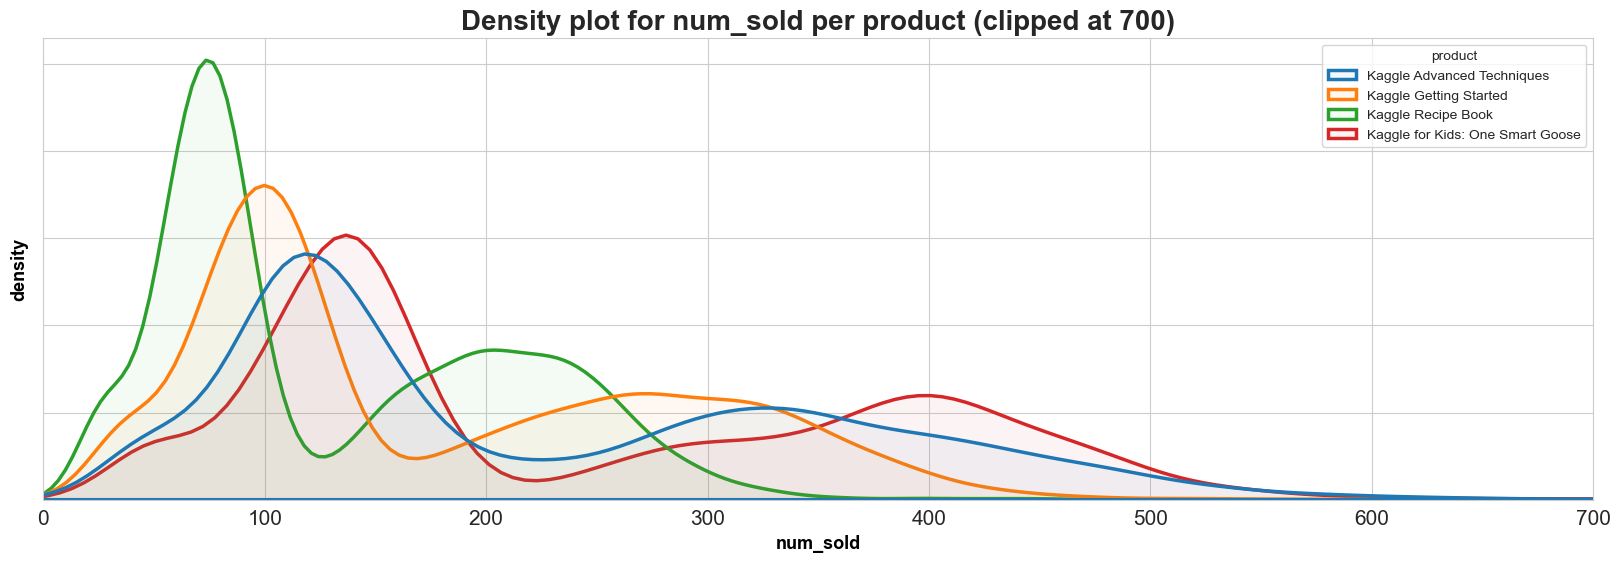

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

sns.kdeplot(data=train, x='num_sold', hue="product", fill=True, alpha=0.05, ax=ax, linewidth=2.5)
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.set_title('Density plot for num_sold per product (clipped at 700)', fontweight='bold', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])

Text(0.5, 1.0, 'num_sold per Country and Date')

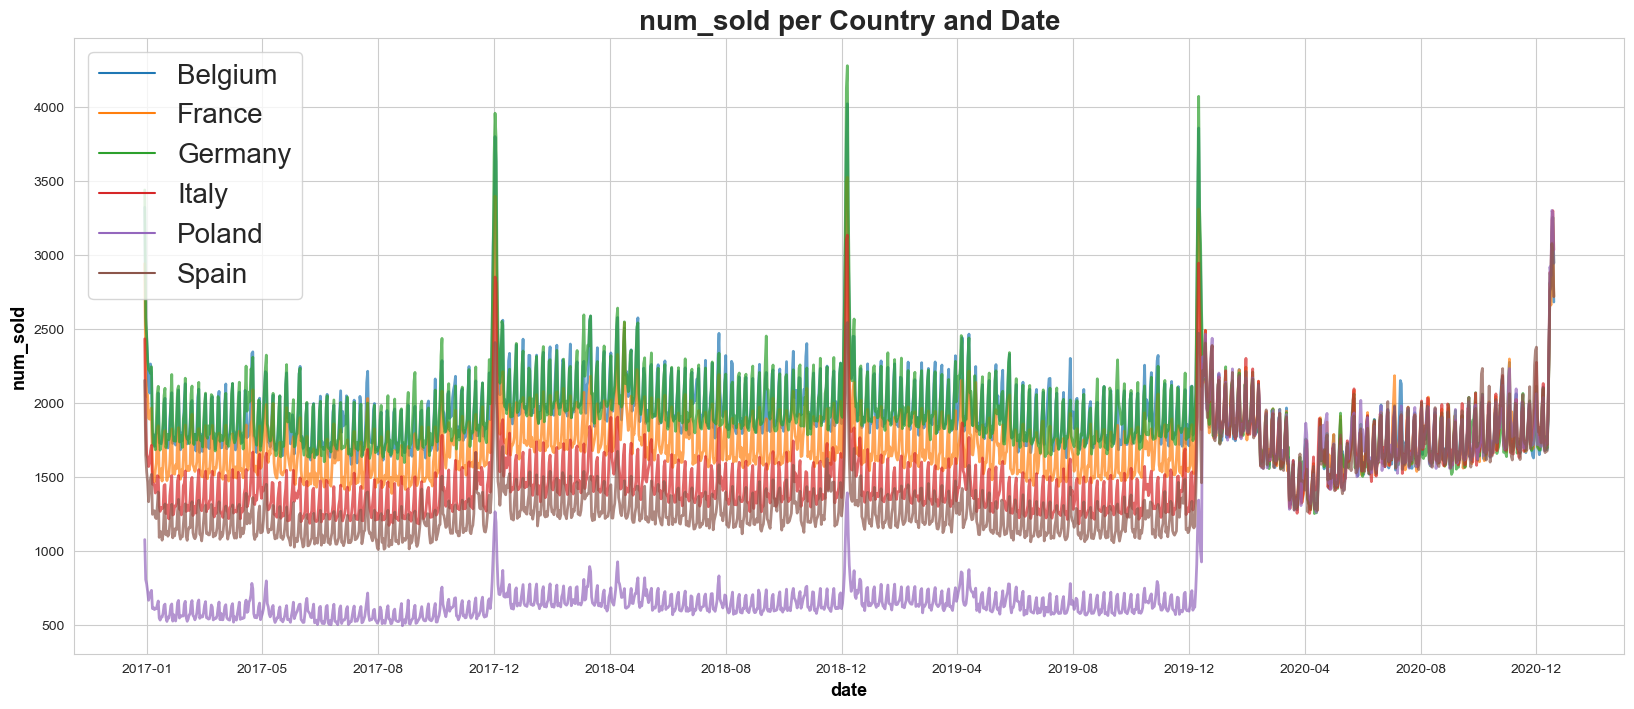

In [42]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(x='date', y='num_sold', hue='country', data=(train.groupby(['date', 'country']).num_sold.sum().rename('num_sold')
                                                          .reset_index().sort_values('date', ascending=True, ignore_index=True)), linewidth=2, alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.legend(fontsize=20, loc='upper left')
ax.set_title('num_sold per Country and Date', fontweight='bold', fontsize=20)


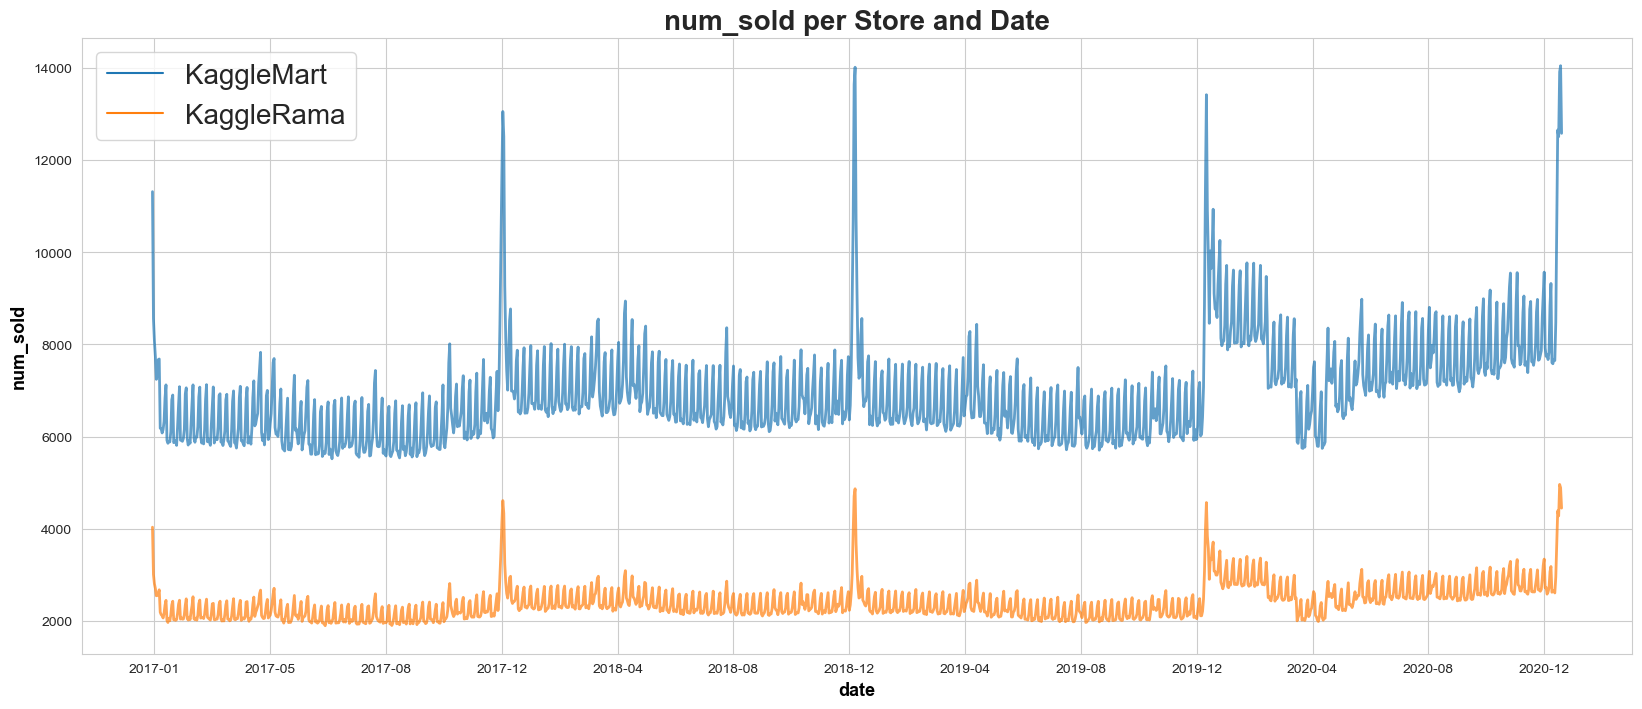

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(x='date', y='num_sold', hue='store', data=(train.groupby(['date', 'store']).num_sold.sum().rename('num_sold')
                                                        .reset_index().sort_values('date', ascending=True, ignore_index=True)), linewidth=2, alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_title('num_sold per Store and Date', fontweight='bold', fontsize=20)
ax.legend(fontsize=20, loc='upper left')

Text(0.5, 1.0, 'num_sold per Product and Date')

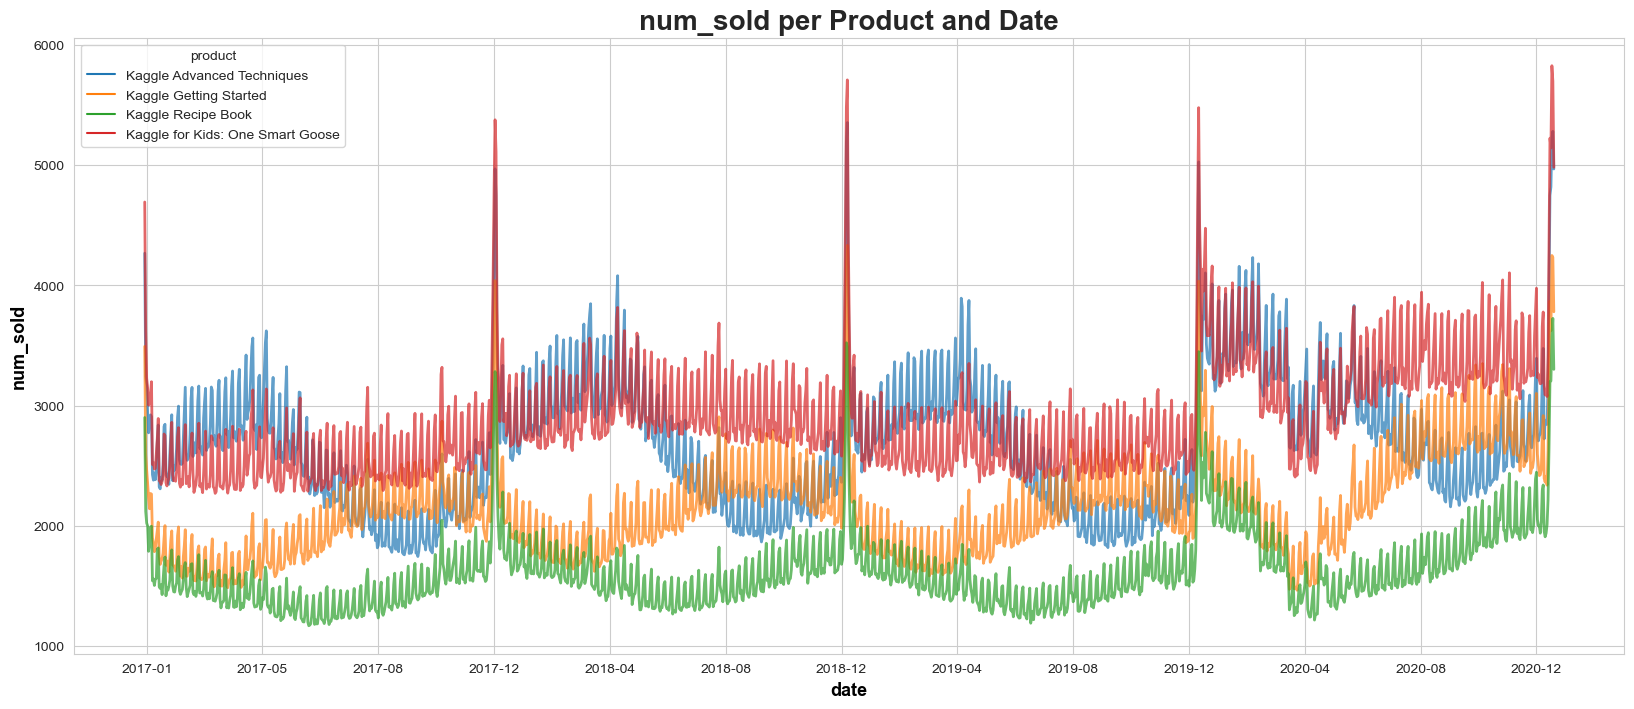

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(x='date', y='num_sold', hue='product', data=(train.groupby(['date', 'product']).num_sold.sum().rename('num_sold')
                                                          .reset_index().sort_values('date', ascending=True, ignore_index=True)), linewidth=2, alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_title('num_sold per Product and Date', fontweight='bold', fontsize=20)

Text(0.5, 1.0, 'Correlation matrix each time series: absolute values inder 0.7 are masked')

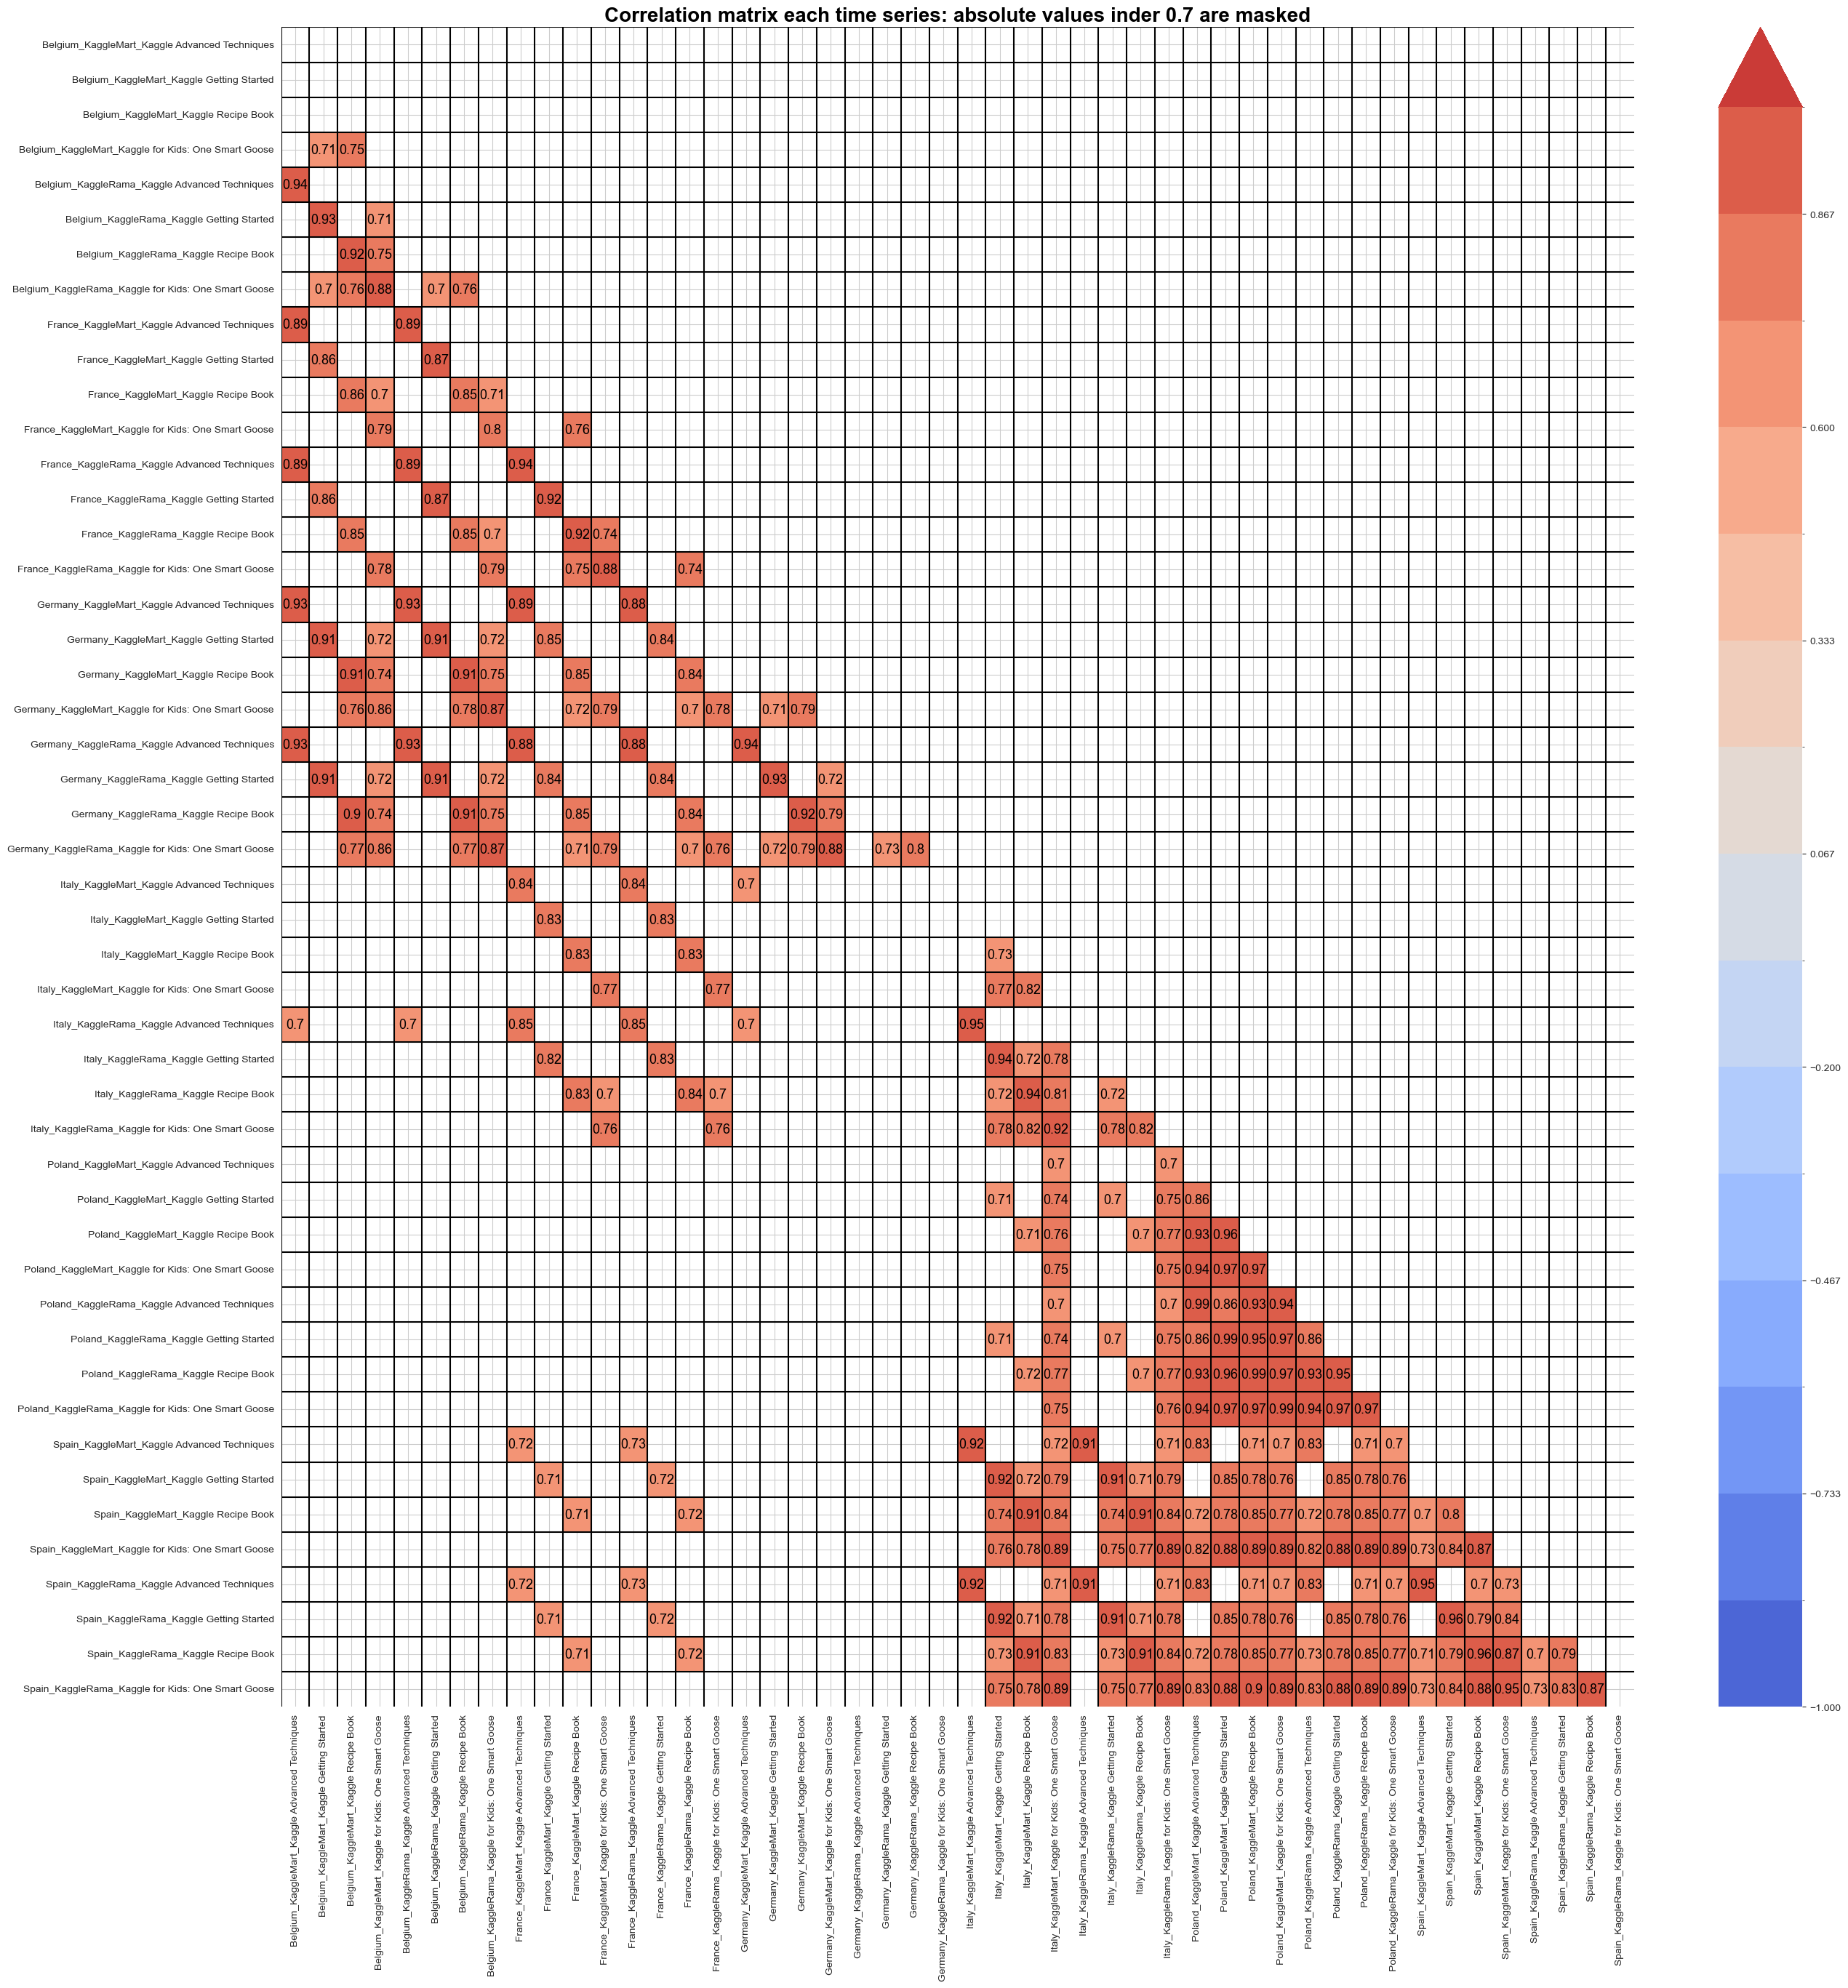

In [45]:
import numpy as np
import matplotlib

all_time_series = (train.drop(['row_id'], axis=1).pivot(columns=['country', 'store', 'product'], index='date', values='num_sold'))
all_time_series.columns = list(map(lambda x: "_".join(x), all_time_series.columns))

corr_matrix = round(all_time_series.corr(), 2)
maxk = np.triu(np.ones_like(corr_matrix, dtype=bool))
colors = sns.color_palette('coolwarm', 16)
levels = np.linspace(-1, 1, 16)
cmap_plot, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='max')

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
mask_feature = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask = mask_feature | (np.abs(corr_matrix) < 0.7),
            annot = True, ax = ax, cbar = True,
            cmap = cmap_plot,
            norm = norm, annot_kws={'size':13, 'color':'black'})
ax.hlines(range(corr_matrix.shape[1]), *ax.get_xlim(), color = 'black')
ax.vlines(range(corr_matrix.shape[1]), *ax.get_ylim(), color='black')

ax.set_title('Correlation matrix each time series: absolute values inder 0.7 are masked',
             fontsize = 20, color = 'black', fontweight = 'bold')


## TFT Model

### Brief Overview
As the paper reports, the TFT Model can handle single or multiple targets and a whole lot of different covariates such as:

- static covariates: these are the ones that do not change through the course of the timeseries. In our case we have country, store and product, but we may have also real ones, such as the average number of people living in cities where a country-store pair resides;

- time series covariates, they actually belong to 2 different groups:
  - known in advance: such as day_of_the_week, month, holidays, etc.
  - unknown in advance: f.i. if we hade the stock level for each product, we would know it just in the past


The great thing is that `pytorch-forecasting` handles everything for us!

## Model Implementation in Pytorch-forecasting

https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Hyperparameter-tuning

In [46]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

data = (data.merge((data[['date']].drop_duplicates(ignore_index=True)
                    .rename_axis('time_idx')).reset_index(), on = ['date']))

In [47]:
import holidays
import gc

# add additional features
data["day_of_week"] = data.date.dt.dayofweek.astype(str).astype("category")  # categories have be strings
data["week_of_year"] = data.date.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_num_sold"] = np.log(data.num_sold + 1e-8)
data["avg_volume_by_country"] = data.groupby(["time_idx", "country"], observed=True).num_sold.transform("mean")
data["avg_volume_by_store"] = data.groupby(["time_idx", "store"], observed=True).num_sold.transform("mean")
data["avg_volume_by_product"] = data.groupby(["time_idx", "product"], observed=True).num_sold.transform("mean")

unique_dates_country = data[['date', 'country']].drop_duplicates(ignore_index = True)
unique_dates_country['is_holiday'] = (unique_dates_country
                                      .apply(lambda x: x.date in holidays.country_holidays(x.country), axis = 1).astype('object'))
unique_dates_country['is_holiday_lead_1'] = (unique_dates_country
                                             .apply(lambda x: x.date+pd.Timedelta(days=1) in holidays.country_holidays(x.country), axis = 1).astype('object'))
unique_dates_country['is_holiday_lead_2'] = (unique_dates_country
                                             .apply(lambda x: x.date+pd.Timedelta(days=2) in holidays.country_holidays(x.country), axis = 1).astype('object'))
unique_dates_country['is_holiday_lag_1'] = (unique_dates_country
                                            .apply(lambda x: x.date-pd.Timedelta(days=1) in holidays.country_holidays(x.country), axis = 1).astype('object'))
unique_dates_country['is_holiday_lag_2'] = (unique_dates_country
                                            .apply(lambda x: x.date-pd.Timedelta(days=2) in holidays.country_holidays(x.country), axis = 1).astype('object'))
data = data.merge(unique_dates_country, on = ['date', 'country'], validate = "m:1")
del unique_dates_country
gc.collect()
data.sample(5, random_state=30)

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_36556/4294741463.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.date.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,row_id,date,country,store,product,num_sold,time_idx,day_of_week,week_of_year,month,log_num_sold,avg_volume_by_country,avg_volume_by_store,avg_volume_by_product,is_holiday,is_holiday_lead_1,is_holiday_lead_2,is_holiday_lag_1,is_holiday_lag_2
51207,51207,2019-12-03,Poland,KaggleRama,Kaggle for Kids: One Smart Goose,48.0,1066,1,49,12,3.871201,74.625,85.125000,202.500000,False,False,False,False,False
7116,7116,2017-05-29,France,KaggleRama,Kaggle Advanced Techniques,146.0,148,0,22,5,4.983607,209.250,88.958333,224.916667,False,False,False,False,False
47561,47561,2019-09-18,Spain,KaggleMart,Kaggle Getting Started,219.0,990,2,38,9,5.389072,135.250,245.166667,187.916667,False,False,False,False,False
39225,39225,2019-03-29,France,KaggleMart,Kaggle Getting Started,253.0,817,4,13,3,5.533389,215.625,277.708333,140.583333,False,False,False,False,False
19956,19956,2018-02-20,Poland,KaggleRama,Kaggle Advanced Techniques,51.0,415,1,8,2,3.931826,79.250,95.291667,237.750000,False,False,False,False,False


In [48]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

max_prediction_length = 365     # we will predict the entire 2021 year
max_encoder_length = train.date.nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length   # we will validate on 2020

In [49]:
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer, NaNLabelEncoder

# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff].drop('row_id', axis = 1),
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"], 
    min_encoder_length=max_prediction_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    time_varying_known_categoricals=["month", "week_of_year", "day_of_week", "is_holiday",
                                     "is_holiday_lead_1", "is_holiday_lead_2",
                                     "is_holiday_lag_1", "is_holiday_lag_2"],
    #variable_groups={"is_holiday": ["is_holiday"]},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "num_sold", "log_num_sold", "avg_volume_by_country",
        "avg_volume_by_store", "avg_volume_by_product"
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["country", "store", "product"], transformation="softplus"
    # ),  # use softplus and normalize by group
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True)
    },
    lags={'num_sold': [7, 30, 365]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

TypeError: TorchNormalizer.transform() missing 1 required positional argument: 'X'